# Importing Libraries

In [228]:
import re
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

torch.manual_seed(2003)

# Cleaning Data

- Data Cleaning and Preprocessing Workflow for News Articles


In [229]:
def clean_data(df):
    # Drop rows where 'content' or 'title' are missing (essential columns for news articles)
    df = df.dropna(
        subset=["title", "content"]
    ).copy()  # Ensures essential columns are non-null

    # Handle missing values in non-essential columns by filling with placeholders or indicators
    df["link"] = df["link"].fillna("No Link")
    df["id"] = df["id"].fillna(-1)
    df["content"] = df["content"].fillna("")

    # Remove duplicate articles based on 'title' and 'content' columns
    df = df.drop_duplicates(subset=["title", "content"]).copy()

    # Additional outlier handling - if 'content' has very few characters, it might not be informative
    df = df[
        df["content"].apply(len) > 50
    ].copy()  # Filter out articles with content shorter than 50 characters

    # Reset index after cleaning
    df = df.reset_index(drop=True)

    return df


# Load the CSV file
file_path = "urdu_articles.csv"
df_urdu = pd.read_csv(file_path)

# Apply the cleaning function to the DataFrame
cleaned_df = clean_data(df_urdu)
# cleaned_df.info()


df_urdu.columns

# Check for duplicates
duplicates_count = cleaned_df.duplicated(subset=["title", "content"]).sum()
print("Number of duplicates:", duplicates_count)

# Check minimum content length
min_length = cleaned_df["content"].apply(len).min()
print("Minimum content length:", min_length)
print("\n")

# Preview cleaned data
print(cleaned_df.head())

Number of duplicates: 0
Minimum content length: 92


   id                                              title  \
0   0  'باہوبلی 2' کے اداکار 47 سال کی عمر میں شادی ک...   
1   1  نیٹ فلکس سیریز تنازع : دھنش نے نینتھارا کے خلا...   
2   2  گلیڈی ایٹر 2' نے باکس آفس پر تہلکہ مچایا، 106 ...   
3   3  والد چنکی پانڈے طویل عرصے تک بےروزگار رہے، انن...   
4   4  رشی کپور نے فلم ’برفی‘ پر بیٹے رنبیر کو کیا مش...   

                                                link  \
0  https://www.express.pk/story/2735199/bahubali2...   
1  https://www.express.pk/story/2735191/netflixse...   
2  https://www.express.pk/story/2735188/gladiator...   
3  https://www.express.pk/story/2735173/chinkypan...   
4  https://www.express.pk/story/2735167/rishikapo...   

                                             content     gold_label  
0  بالی ووڈ اور ساؤتھ انڈین فلم انڈسٹری کے معروف ...  entertainment  
1  تامل فلم انڈسٹری کے دو مشہور ستاروں، دھنش اور ...  entertainment  
2  ہالی وڈ کی دو بڑی فلموں، میوزیکل ایڈ

## Tokenization and Bag of Words Analysis for Urdu News Articles

In [230]:
# Installing urduhack to use for tokenization
# %pip install urduhack

# %pip install tensorflow

In [231]:
def tokenize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = re.findall(r"\w+", text)
    return tokens


# Create a Bag of Words model for tokenizing and counting word frequencies
def create_bag_of_words(text_series):
    bow = Counter()
    for text in text_series:
        tokens = tokenize_text(text)
        bow.update(tokens)
    return bow


# Tokenizing and creating Bag of Words for titles and contents
title_bow = create_bag_of_words(cleaned_df["title"])
content_bow = create_bag_of_words(cleaned_df["content"])

# Print the most common words in titles and contents
print("Top 20 words in titles:")
for word, freq in title_bow.most_common(20):
    print(f"{word}: {freq}")

print("\nTop 20 words in contents:")
for word, freq in content_bow.most_common(20):
    print(f"{word}: {freq}")


def create_bow_feature_matrix(text_series, vocabulary):
    num_documents = len(text_series)
    vocab_size = len(vocabulary)

    feature_matrix = np.zeros((num_documents, vocab_size), dtype=int)
    word_to_index = {word: index for index, word in enumerate(vocabulary)}

    for doc_idx, text in enumerate(text_series):
        tokens = tokenize_text(text)

        token_counts = {}
        for token in tokens:
            token_counts[token] = token_counts.get(token, 0) + 1

        for token, count in token_counts.items():
            if token in word_to_index:
                word_idx = word_to_index[token]
                feature_matrix[doc_idx, word_idx] = count

    return feature_matrix


combined_vocabulary = list(set(title_bow.keys()).union(content_bow.keys()))
X_title = create_bow_feature_matrix(cleaned_df["title"], combined_vocabulary)
X_content = create_bow_feature_matrix(cleaned_df["content"], combined_vocabulary)
X_combined = np.hstack((X_title, X_content))

Top 20 words in titles:
کی: 527
میں: 499
کا: 485
کے: 379
سے: 269
نے: 233
پر: 228
کو: 207
ا: 188
اور: 113
پاکستان: 107
کیلئے: 81
ہے: 68
پی: 68
سی: 66
کر: 64
کرنے: 62
اضافہ: 61
اے: 57
ٹرافی: 54

Top 20 words in contents:
کے: 11297
میں: 8529
کی: 8086
ہے: 5789
سے: 5224
نے: 5042
اور: 4295
کا: 4164
کہ: 3865
کو: 3752
پر: 3613
ا: 2710
ہیں: 2251
اس: 2137
کیا: 1794
بھی: 1738
ایک: 1634
کر: 1392
یہ: 1285
گیا: 1233


# Train / Validation / Test Split

In [232]:
label_encoder = LabelEncoder()
cleaned_df["label"] = label_encoder.fit_transform(cleaned_df["gold_label"])

# Train: 60% | Validation: 20% | Test: 20%

X_train, X_temp, y_train, y_temp = train_test_split(
    X_combined,
    cleaned_df["label"],
    test_size=0.4,
    random_state=2003,
    shuffle=True,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=2003, shuffle=True
)


# Convert labels to NumPy arrays
y_train = y_train.values  # or y_train.to_numpy()
y_val = y_val.values
y_test = y_test.values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)

# TextClassifier Class

In [233]:
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)


input_dim = X_train_tensor.shape[1]  # number of features(words in vectorised text)
hidden_dim = 256
output_dim = len(label_encoder.classes_)  # Number of categories

model = TextClassifier(input_dim, hidden_dim, output_dim)
# print(model)

# Training Loop

In [234]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 15
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output_train = model(X_train_tensor)
    loss_train = criterion(output_train, y_train_tensor)
    loss_train.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        output_val = model(X_val_tensor)
        loss_val = criterion(output_val, y_val_tensor)

        _, predicted_train = torch.max(output_train, 1)
        correct_train = (predicted_train == y_train_tensor).sum().item()
        accuracy_train = correct_train / len(y_train_tensor) * 100

        _, predicted_val = torch.max(output_val, 1)
        correct_val = (predicted_val == y_val_tensor).sum().item()
        accuracy_val = correct_val / len(y_val_tensor) * 100

    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())
    train_accuracies.append(accuracy_train)
    val_accuracies.append(accuracy_val)

    print(f"Epoch {epoch + 1} out of {epochs}:")
    print(f"  Train Loss: {loss_train.item()}, Train Accuracy: {accuracy_train}")
    print(f"  Val Loss: {loss_val.item()}, Val Accuracy: {accuracy_val}\n")

Epoch 1 out of 15:
  Train Loss: 1.6086766719818115, Train Accuracy: 24.963289280469898
  Val Loss: 1.5517528057098389, Val Accuracy: 77.09251101321586

Epoch 2 out of 15:
  Train Loss: 1.5368057489395142, Train Accuracy: 86.78414096916299
  Val Loss: 1.464196801185608, Val Accuracy: 86.34361233480176

Epoch 3 out of 15:
  Train Loss: 1.4234343767166138, Train Accuracy: 95.00734214390602
  Val Loss: 1.3637287616729736, Val Accuracy: 92.07048458149781

Epoch 4 out of 15:
  Train Loss: 1.2933889627456665, Train Accuracy: 98.09104258443465
  Val Loss: 1.2715861797332764, Val Accuracy: 94.7136563876652

Epoch 5 out of 15:
  Train Loss: 1.1792973279953003, Train Accuracy: 98.6784140969163
  Val Loss: 1.1939198970794678, Val Accuracy: 96.0352422907489

Epoch 6 out of 15:
  Train Loss: 1.0921300649642944, Train Accuracy: 98.97209985315712
  Val Loss: 1.1326160430908203, Val Accuracy: 96.0352422907489

Epoch 7 out of 15:
  Train Loss: 1.0298857688903809, Train Accuracy: 99.26578560939795
  Val

# Plotting Loss and Accuracy Curves

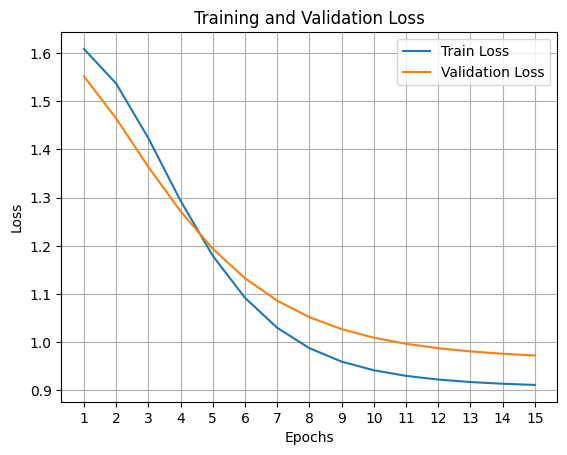

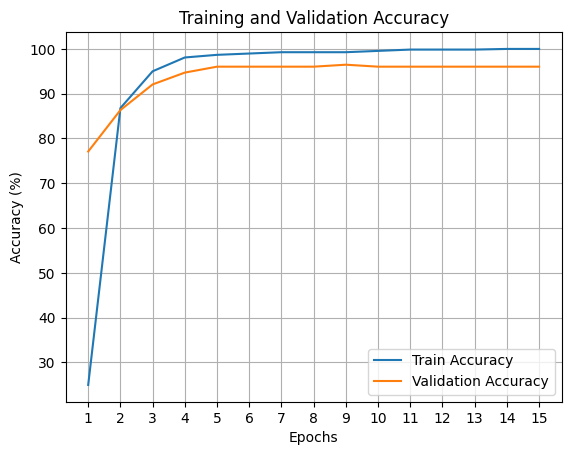

In [235]:
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.xticks(range(1, epochs + 1))
plt.show()

plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.xticks(range(1, epochs + 1))
plt.show()

# Evaluating on Test Set

Test Accuracy: 97.80701754385966%
Test Loss: 0.9619189500808716


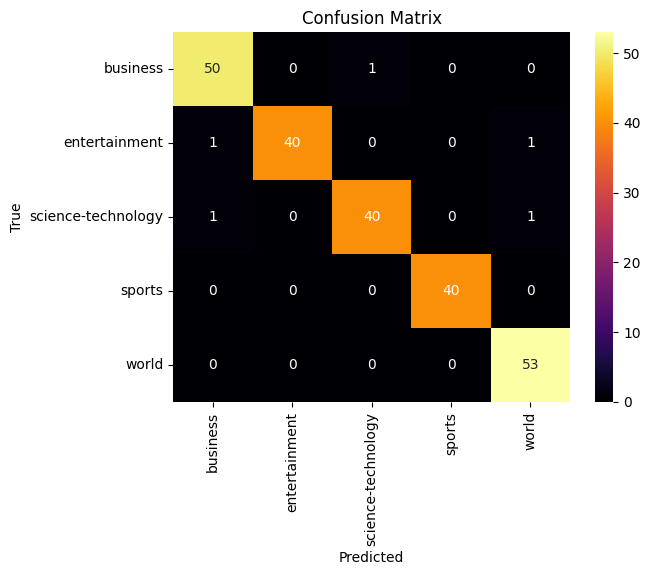

In [238]:
model.eval()

with torch.no_grad():
    output_test = model(X_test_tensor)
    loss_test = criterion(output_test, y_test_tensor)
    _, predicted_test = torch.max(output_test, 1)
    correct_test = (predicted_test == y_test_tensor).sum().item()
    accuracy_test = correct_test / len(y_test_tensor) * 100

print(f"Test Accuracy: {accuracy_test}%")
print(f"Test Loss: {loss_test}")

y_test_np = y_test_tensor.numpy()
predicted_test_np = predicted_test.numpy()
class_names = label_encoder.classes_

conf_matrix = confusion_matrix(y_test_np, predicted_test_np)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='inferno',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visible Proof of Model Correctness
- Small function that outputs a bunch of article titles and their predicted / true labels

In [239]:
def display_labels_mapping(label_encoder):
    classes = label_encoder.classes_

    print("Integer Label -> Category Name Mapping:")
    for i, label in enumerate(classes):
        print(f"{i} -> {label}")


# display_labels_mapping(label_encoder)


def predict(title_text, content_text, model, vocabulary):
    model.eval()
    vocab_to_index = {word: idx for idx, word in enumerate(vocabulary)}
    
    #Title
    title_tokens = tokenize_text(title_text)
    title_token_counts = Counter(title_tokens)
    title_vec = np.zeros(len(vocabulary), dtype=np.float32)
    for token, count in title_token_counts.items():
        if token in vocab_to_index:
            title_vec[vocab_to_index[token]] = count
    
    #Context
    content_tokens = tokenize_text(content_text)
    content_token_counts = Counter(content_tokens)
    content_vec = np.zeros(len(vocabulary), dtype=np.float32)
    for token, count in content_token_counts.items():
        if token in vocab_to_index:
            content_vec[vocab_to_index[token]] = count
    
    #Combine both vectors
    text_vec = np.concatenate([title_vec, content_vec])
    text_tensor = torch.tensor([text_vec], dtype=torch.float32)
    
    with torch.no_grad():
        output = model(text_tensor)
        _, predicted = torch.max(output, 1)

    predicted_label = ""
    if predicted.item() == 0:
        predicted_label = "business"
    elif predicted.item() == 1:
        predicted_label = "entertainment"
    elif predicted.item() == 2:
        predicted_label = "science-technology"
    elif predicted.item() == 3:
        predicted_label = "sports"
    elif predicted.item() == 4:
        predicted_label = "world"

    return predicted_label

combined_vocabulary = list(set(title_bow.keys()).union(content_bow.keys()))

for i in range(20):
    random_article_row = cleaned_df.sample(n=1).iloc[0]
    title_text = random_article_row["title"]
    content_text = random_article_row["content"]
    true_label = random_article_row["gold_label"]
    
    # Predict label using both title and content
    predicted_label = predict(title_text, content_text, model, combined_vocabulary)
    
    print(f"Article {i+1}:\n")
    print(f"Title: {title_text}\n")
    print(f"True Category: {true_label}")
    print(f"Predicted Category: {predicted_label}\n")
    print("-" * 80)


Article 1:

Title: پاکستانی حکام کے ساتھ مذاکرات مثبت رہے، آئی ایم ایف کا اعلامیہ جاری

True Category: business
Predicted Category: business

--------------------------------------------------------------------------------
Article 2:

Title: پاکستان میں سُپر بلیو مون کا نظارہ کرنا کب ممکن ہوگا؟

True Category: science-technology
Predicted Category: science-technology

--------------------------------------------------------------------------------
Article 3:

Title: نئی فلم کی شوٹنگ سے پہلے رنویر سنگھ کا گولڈن ٹیمپل کا دورہ

True Category: entertainment
Predicted Category: entertainment

--------------------------------------------------------------------------------
Article 4:

Title: محبت کی کہانی مکمل اور جاری رکھنے کیلئے شادی نہیں کرنی چاہیے: توثیق حیدر

True Category: entertainment
Predicted Category: entertainment

--------------------------------------------------------------------------------
Article 5:

Title: فرانس؛ 72 اجنبیوں سے بیوی کیساتھ جنسی زیادتی کروانے والے شوہر کو 20